In [1]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.7 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
"""
Methodology:

I lack the time to explore different design options, so in case you were wondering "why do this?" it's mostly arbitrary lol. I don't have time to justify or evaulate reasons
beyond LSTM = probably good for timeseries prediction idk. I generally try to follow ML/RL conventions but besides that not much of a design process.

We'll define the available actions to an agent as either "buy", "sell", or "hold" so our portfolio will always consist of some combination of liquid cash and stock.
We'll start with a capital of $10k.
We'll use something similar to a n-step temporal difference, where we attempt to look into the future to predict expected reward.
However, rather than reward, we'll be predicting the price values using a pre-trained LSTM. This is a little different from the papers, since they use a relative price vector.
Naturally, as we look further into the future, our LSTM prediction will be become
less and less accurate. We'll need to retrain our LSTM with the updated data periodically (every M timesteps) in the real world - however, since we already have all
the historical pricing, we'll pretrain the LSTM and the agent first, and evaluate the test data as though it were a single interval, ie timesteps < M (no retraining).
Define the reward functions as the rate of return compared to the previous timestep.
No transaction fee will be included.

Intuition: LSTM will predict prices, RL agent will take predictions as state and learn when to sell/buy based on reward (ROR)
"""

class Stonk:
    """Serves as both a wrapper class for yfinance Tickers and a dataloader for prices."""
    def __init__(self, symbol: str, seq_length: int, features: list[str] = ['Close', 'Open', 'High', 'Low']):
        self.stonk = yf.Ticker(symbol)
        self.hist = self.stonk.history(period="max")

        # normalize the price features
        # unlike the paper we normalize using the standard method (see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
        # not completely sure how the papers handle the first datapoint for each stock, since there's no previous price to normalize by
        self.scaler = MinMaxScaler()
        normalized_features = self.scaler.fit_transform(self.hist[features])
        for i, column in enumerate(features):
            self.hist[f'Normalized_{column}'] = normalized_features[:, i]

        self.hist.reset_index(inplace=True)

        # set price tensor to closing prices only - we'll train on just this feature for now
        # the column is by default a numpy array with dim (T), where T is total length of history aka time
        # reshaping is done based on input size to the LSTM - since we only train on single feature, our input size is 1
        self.prices = self.hist['Normalized_Close'].values.reshape(-1, 1) # reshape to dim (T, 1)

        # data preprocessing
        # L - sequence length
        # T - time
        sequences = []
        labels = []
        for i in range(len(self.prices) - seq_length):
            seq = self.prices[i:i + seq_length]
            label = self.prices[i + seq_length]
            sequences.append(seq)
            labels.append(label)

        sequences = np.array(sequences) # (T, L, 1)
        labels = np.array(labels) # (T, 1)

        # split 75/25 train/test
        # note that T still represents time, but is now split across train/test
        # shuffle=False guarantees chronological order
        # the first 75% of the history is training, last 25% is test
        # this distribution definitely has some issues but would take too much time to fix
        dataset = train_test_split(sequences, labels, shuffle=False) # [(T, L, 1), (T, L, 1), (T, 1), (T, 1)]
        dataset = [torch.tensor(data_split, dtype=torch.float32, device=device) for data_split in dataset]

        # X - data
        # Y - label
        self.x_train, self.x_test, self.y_train, self.y_test = dataset


In [5]:
class LSTM(nn.Module):
    """standard lstm implementation"""
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # hidden state (h0) and cell state (c0) initialization
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, _ = self.lstm(x, (h0, c0))

        out = out[:, -1, :] # only pass hidden states from the last timestep

        return self.fc(out)

In [19]:
# HYPERPARAMS
seq_length = 50
num_epochs = 300
hidden_size = 128
num_layers = 2
output_size = 1
input_size = 1
learning_rate = 0.001

run = wandb.init(
    project="test-stonk",
    # name="test-lstm-init1",
    config={
        "learning_rate": learning_rate,
        "epochs": num_epochs,
        "seq_length": seq_length,
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "output_size": output_size,
        "input_size": input_size
    }
)

loss,██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁
loss,0.0


In [9]:
msft = Stonk("MSFT", seq_length, features=['Close'])

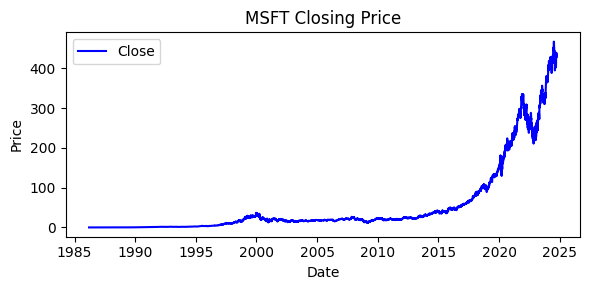

In [10]:
plt.figure(figsize=(6, 3))
plt.plot(msft.hist['Date'], msft.hist['Close'], label='Close', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('MSFT Closing Price')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
lstm = LSTM(input_size, hidden_size, num_layers, output_size)
lstm.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(lstm.parameters(), lr=learning_rate)

In [12]:
msft.x_test.shape # shape should be (T, seq_length, 1)

torch.Size([2416, 50, 1])

In [21]:
result = lstm(msft.x_train) # test prediction
result

tensor([[-0.0007],
        [-0.0007],
        [-0.0007],
        ...,
        [-0.0001],
        [-0.0001],
        [-0.0001]], device='cuda:0', grad_fn=<AddmmBackward0>)

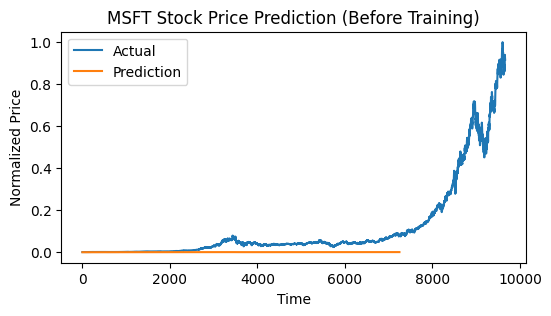

In [22]:
plt.figure(figsize=(6, 3))
plt.plot(np.concatenate((msft.y_train.cpu().numpy(), msft.y_test.cpu().numpy())), label='Actual')
plt.plot(result.cpu().detach().numpy(), label='Prediction')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.title('MSFT Stock Price Prediction (Before Training)')
plt.legend()
plt.show()

In [23]:
from decimal import Decimal

for epoch in range(num_epochs):
    outputs = lstm(msft.x_train)
    loss = criterion(outputs, msft.y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    run.log({"loss": loss.item()})
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {Decimal(loss.item()):.10e}')

# overfitted but whatever

Epoch [10/300], Loss: 5.1320932107e-4
Epoch [20/300], Loss: 5.3818122251e-4
Epoch [30/300], Loss: 4.7105096746e-4
Epoch [40/300], Loss: 4.4912495650e-4
Epoch [50/300], Loss: 3.7793396041e-4
Epoch [60/300], Loss: 8.4770923422e-5
Epoch [70/300], Loss: 6.4252679294e-5
Epoch [80/300], Loss: 3.7389854697e-5
Epoch [90/300], Loss: 1.6782874809e-5
Epoch [100/300], Loss: 6.0300308178e-6
Epoch [110/300], Loss: 3.8103351017e-6
Epoch [120/300], Loss: 3.1696772567e-6
Epoch [130/300], Loss: 3.0029693789e-6
Epoch [140/300], Loss: 2.9036414162e-6
Epoch [150/300], Loss: 2.8269514587e-6
Epoch [160/300], Loss: 2.8060112527e-6
Epoch [170/300], Loss: 2.7958772080e-6
Epoch [180/300], Loss: 2.7833766580e-6
Epoch [190/300], Loss: 2.7725682230e-6
Epoch [200/300], Loss: 2.7622754715e-6
Epoch [210/300], Loss: 2.7519542982e-6
Epoch [220/300], Loss: 2.7417813726e-6
Epoch [230/300], Loss: 2.7316723390e-6
Epoch [240/300], Loss: 2.7215735372e-6
Epoch [250/300], Loss: 2.7114865588e-6
Epoch [260/300], Loss: 2.701390258

In [36]:
run.finish()

Test Loss: 0.0085
(2416,)


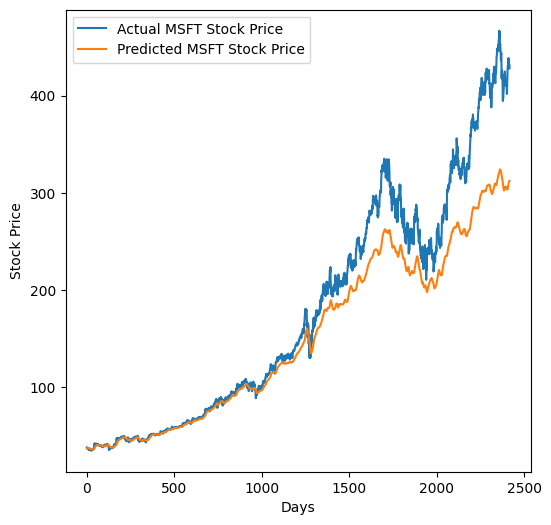

In [27]:
"""
This evaluation method isn't the greatest, def has issues but can be fixed later
"""
with torch.no_grad():
    test_predictions = lstm(msft.x_test)
    test_loss = criterion(test_predictions, msft.y_test)
    print(f'Test Loss: {test_loss.item():.4f}')
    print(test_predictions.cpu().squeeze(1).numpy().shape)
    # Inverse transform the predicted and actual values to get original stock prices
    predicted_stock_price = msft.scaler.inverse_transform(test_predictions.cpu().numpy())
    actual_stock_price = msft.scaler.inverse_transform(msft.y_test.cpu().numpy().reshape(-1, 1))

# 7. Plotting the results
plt.figure(figsize=(6, 6))
plt.plot(actual_stock_price, label="Actual MSFT Stock Price")
plt.plot(predicted_stock_price, label="Predicted MSFT Stock Price")
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [49]:
import torch.optim as optim
import torch.nn.functional as F

class Actor(nn.Module):
    def __init__(self, n_obs, layer_size, n_actions):
        super().__init__()
        self.l1 = nn.Linear(n_obs, 64)
        self.l2 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = F.relu(self.l1(x))
        return self.l2(x)

predicted_prices = lstm(msft.x_train).detach()
actual_stock_price = msft.scaler.inverse_transform(msft.y_train.cpu().numpy().reshape(-1, 1)).squeeze(1)
actual_stock_price

array([ 0.06636955,  0.06851035,  0.07065117, ..., 37.694275  ,
       38.00622   , 38.257523  ], dtype=float32)

In [50]:
# HYPERPARAMS
window_size = 10
num_epochs = 5
layer_size = 64
learning_rate = 0.001
starting_capital = 10000
gamma = 0.99
trading_quantity = 10

run = wandb.init(
    project="test-stonk",
    config={
        "window_size": window_size,
        "epochs": num_epochs,
        "layer_size": layer_size,
        "learning_rate": learning_rate,
        "initial_portfolio_value": starting_capital,
        "gamma": gamma,
        "trading_quantity": trading_quantity
    }
)

In [51]:
policy = Actor(window_size, layer_size, 3) # for simplicity we will discretize the actions in fixed quantities of 10
# we will also fix the window size at 10 timesteps
policy.to(device)
optimizer = optim.AdamW(policy.parameters(), lr=learning_rate)
policy

Actor(
  (l1): Linear(in_features=10, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=3, bias=True)
)

In [52]:
first_epoch = {
    "actions": [],
    "portfolio_value": []
}
last_epoch = {
    "actions": [],
    "portfolio_value": []
}

In [55]:
from torch.distributions import Categorical
from collections import deque

for epoch in range(num_epochs):
  rewards_history = []
  log_probs_history = []
  total_rewards = deque([])
  action_history = []
  portfolio_value_history = []
  portfolio = {
    'stock': 0,
    'cash': starting_capital
  }

  for i in range(1, len(predicted_prices) - window_size):
      state = predicted_prices[i:i + window_size].view(1, -1)
      # print(state.shape)
      logits = policy(state)
      # print(state)
      # print(logits)

      action_distr = Categorical(logits=logits)
      action = action_distr.sample()

      # print(action)
      log_probs_history.append(action_distr.log_prob(action))

      prev_portfolio_value = portfolio['cash'] + portfolio['stock'] * actual_stock_price[i - 1]

      if action == 0:
          # sell
          if portfolio['stock'] >= trading_quantity:
              portfolio['cash'] += actual_stock_price[i] * trading_quantity
              portfolio['stock'] -= trading_quantity
      elif action == 1:
          # buy
          if portfolio['cash'] >= trading_quantity * actual_stock_price[i]:
              portfolio['cash'] -= actual_stock_price[i] * trading_quantity
              portfolio['stock'] += trading_quantity
      elif action == 2:
          # hold
          pass
      # print(portfolio)
      action_history.append(action)

      new_portfolio_value = portfolio['cash'] + portfolio['stock'] * actual_stock_price[i]

      # calculate reward
      reward = (new_portfolio_value) / prev_portfolio_value - 1
      # print(reward)
      rewards_history.append(reward)
      total_rewards.append(reward)

      portfolio_value_history.append(new_portfolio_value) # record portfolio value

      if (i + 1) % window_size == 0:  # Update policy every window_size number of steps

          discounted_reward = 0
          for r in rewards_history[::-1]:
              # computes the discounted reward at that timestep
              # assuming we have rewards = [1, 1, 1, 1]
              # our total rewards would be [3.439, 2.71, 1.9, 1] representing all future rewards
              # obtained by the agent starting from that timestep
              discounted_reward = r + gamma * discounted_reward
              total_rewards.appendleft(discounted_reward)

          total_rewards = torch.tensor(total_rewards, device=device)
          # print(total_rewards)
          # print(log_probs_history)
          losses = []
          for log_prob, r in zip(log_probs_history, total_rewards):
              # we add the negative here because the optimizer expects us to perform gradient descent
              # but we want ascent so we just flip our values around
              losses.append(-r * log_prob)
          # print(losses)
          loss = torch.cat(losses).sum()
          run.log({"loss": loss.item()})

          rewards_history = []
          log_probs_history = []
          total_rewards = deque([])

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

  if epoch == 0:
    first_epoch["actions"] = action_history[:]
    first_epoch["portfolio_value"] = portfolio_value_history[:]
  elif epoch == num_epochs - 1:
    last_epoch["actions"] = action_history[:]
    last_epoch["portfolio_value"] = portfolio_value_history[:]

  total_return = (portfolio_value_history[-1] - starting_capital) / starting_capital
  run.log({"total_return": total_return, "final_portfolio_value": portfolio_value_history[-1]})
  print(f"Epoch [{epoch+1}/{num_epochs}] Total Return: {total_return:.4f} Final Portfolio Value: {portfolio_value_history[-1]}")

  # wtf happened at epoch 4

Epoch [1/5] Total Return: -0.0764 Final Portfolio Value: 9236.318245977163
Epoch [2/5] Total Return: 0.7275 Final Portfolio Value: 17274.892873242497
Epoch [3/5] Total Return: 1.2747 Final Portfolio Value: 22747.016291990876
Epoch [4/5] Total Return: 4.5138 Final Portfolio Value: 55138.10828469694
Epoch [5/5] Total Return: 1.1519 Final Portfolio Value: 21519.35908962041


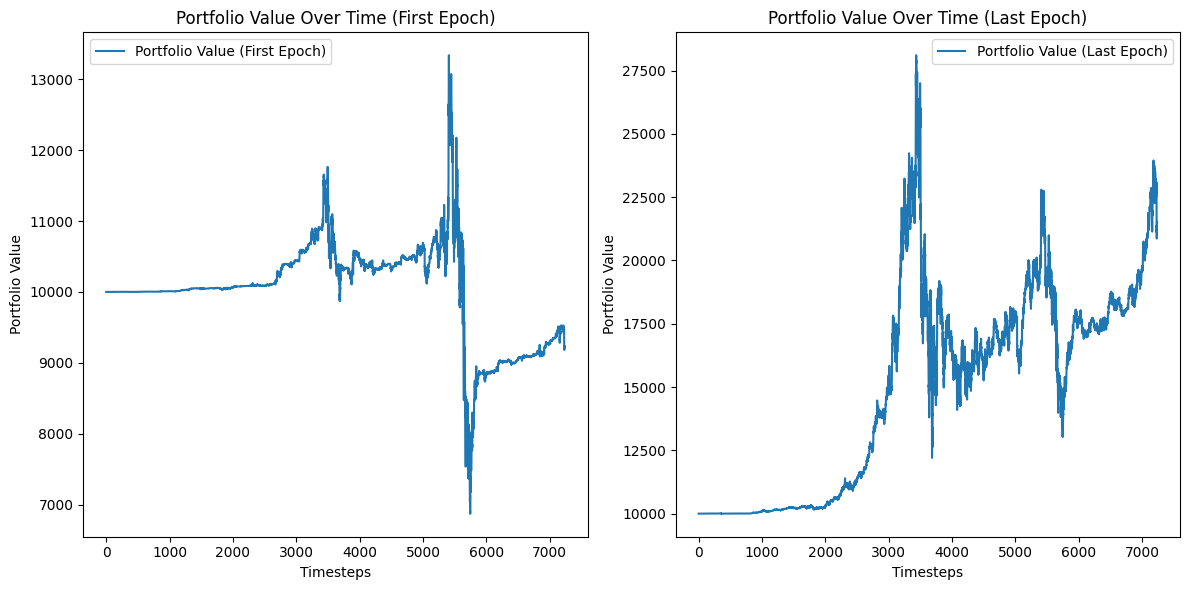

In [56]:
# prompt: plot the portfolio values over time for the first and last epochs

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(first_epoch["portfolio_value"], label="Portfolio Value (First Epoch)")
plt.xlabel('Timesteps')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time (First Epoch)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(last_epoch["portfolio_value"], label="Portfolio Value (Last Epoch)")
plt.xlabel('Timesteps')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time (Last Epoch)')
plt.legend()

plt.tight_layout()
plt.show()


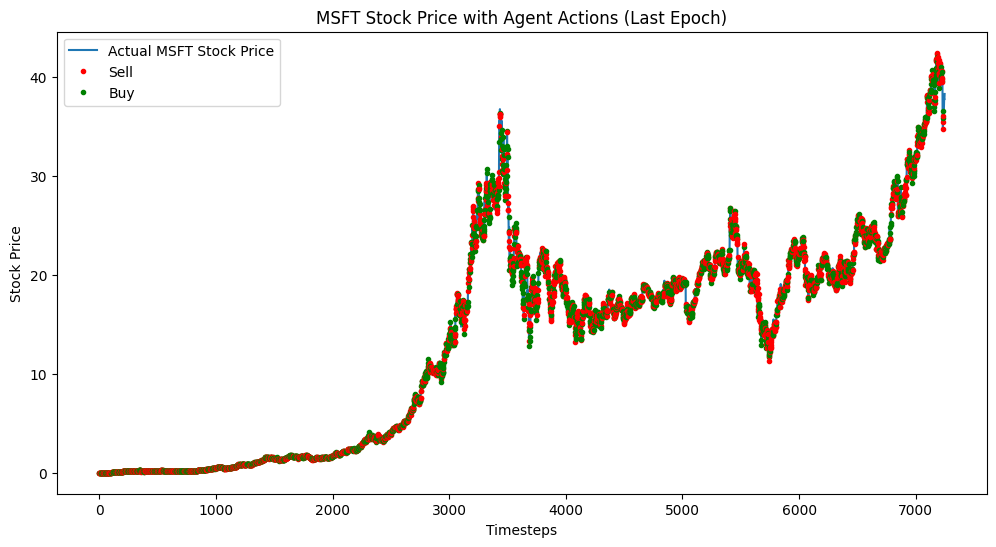

In [77]:
# prompt: plot the actions during the last epoch on the same graph as the actual stock prices

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(actual_stock_price, label="Actual MSFT Stock Price")

# Iterate through actions and plot buy/sell markers
for i, action in enumerate(last_epoch["actions"]):
    if action == 0:  # Sell
        plt.plot(i, actual_stock_price[i], 'ro', markersize=3, label="Sell" if "Sell" not in plt.gca().get_legend_handles_labels()[1] else "_nolegend_")
    elif action == 1:  # Buy
        plt.plot(i, actual_stock_price[i], 'go', markersize=3, label="Buy" if "Buy" not in plt.gca().get_legend_handles_labels()[1] else "_nolegend_")


plt.xlabel('Timesteps')
plt.ylabel('Stock Price')
plt.title('MSFT Stock Price with Agent Actions (Last Epoch)')
plt.legend()
plt.show()

"""
This plot is pretty hard to read, you can kinda see the agent buying when the price goes up and selling when it goes down, but I don't really have time to improve it.
Have to go finish the papers now lol \\(*_||
"""

In [73]:
# prompt: generate the table showing the stats for the last epoch: show action type (it is an integer), current portfolio value, current stock price

import pandas as pd

# Assuming last_epoch["actions"], last_epoch["portfolio_value"], and actual_stock_price are defined

action_mapping = {
    0: "Sell",
    1: "Buy",
    2: "Hold"
}

data = []
for i in range(len(last_epoch["actions"])):
  data.append([
      action_mapping.get(last_epoch["actions"][i].item(), "Unknown"),
      last_epoch["portfolio_value"][i],
      actual_stock_price[i]
  ])

df = pd.DataFrame(data, columns=["Action Type", "Portfolio Value", "Stock Price"])
print(df)


     Action Type  Portfolio Value  Stock Price
0           Sell     10000.000000     0.066370
1           Sell     10000.000000     0.068510
2            Buy     10000.000000     0.070651
3            Buy     10000.026760     0.072257
4           Hold      9999.983944     0.074933
...          ...              ...          ...
7232        Sell     21154.370457    34.760643
7233        Hold     21256.246640    35.517796
7234         Buy     21332.652013    35.793137
7235        Sell     21532.090260    35.999638
7236         Buy     21519.359090    36.524475

[7237 rows x 3 columns]


In [57]:
run.finish()

final_portfolio_value,▃▃▃▃▃▁▂▃█▃
loss,▄▄▄▄▄▅▃▄▄▄▄▄▃▅▆▄▄▄▄▄▃▆▇▅▄▄▆▂▇▆▁▁▄█▄▁▄▄▃▄
total_return,▃▃▃▃▃▁▂▃█▃
final_portfolio_value,21519.35909
loss,-0.52799
total_return,1.15194
